# This notebook is written to aggregate data preprocessed in this dataset and share a single folder with Sungtae. Please see instruction below:

## 0. Prior to running this code, please make sure the data and the script follows the following hierarchical structure:
```
├── data
│   ├── stage3
│   │   └── win60_overlap90
│   ├── stage4_UNet_test
│   │   └── CDC_dataset
└── repo
    └── collaboration
        └── aggregate_data.ipynb
```
## 1. The following items are stored into a single `feather` file for a subject (101 to 212) and a task (e.g., baseline, walking, etc.):
- [X] give Sungtae raw triaxial ACC signals and raw ECG with their respective timestamps (resampled to 250 Hz)
- [X] reference RR and VO2 from cosmed (breath-by-breath) with their respective timestamps (resampled to 250 Hz)
- [X] estimated HR from patch (beat-by-beat) with their respective timestamps (resampled to 250 Hz)

## 2. The following items are stored into a single `csv` file for all subjects and all tasks:
- [X] estimated RR from patch a 60s window (-30 to 30s relative to the timestamp) with their respective timestamps (1/3 Hz)

## 3. Notes on the protocol.

The tasks in this study include Baseline, 6MWT, 6MWT-R (resistive breathing), StairDown0, StairUp0, StairDown1 (there is a 5s pause between these stair tasks), outdoor walk (include some minor incline and decline surface, which should show up in the pres(sure) column of the patch), outdoor run.

Stair climbing task: subject started at the 3rd floor, 
- [X] `walked down (StairDown0)` to the bottom floor, paused for 5s, then 
- [X] `walked all the way up (StairUp0)` to the top floor, and finally 
- [X] `walked back down (StairDown1)` to the 3rd floor. Each of these 3 tasks are segmented in the middle of the 5s pause.

Outdoor walking task: subject walked a pre-determined route with minor incline and decline surface. There is a short stair near the end of this task, but it is segmented out (based on timestamps annotated by the study investigators) as requested by Sungtae. You may use the pres(sure) column of the `df_sync_extracted` to check the incline/decline level
- [X] `Walk`

Outdoor running task: one subject 
(**please exlcude subject 111 since this subject transitioned to walking near the end of the run**
- [X] `Run`

## 4. The following sample code has been provided to read the data:
- [X] reading feather file (of wearable signals, cosmed label, demographic data, etc.) for each subject and each task, one at a time
- [X] reading a single csv file (of RR estimates) for all subjects and all tasks

## Final notes on subjects exclusion:
* Excluded subjects (N=3):
    * sub 101-103: These subjects used ECG electrodes that are susceptible to detaching as sweat accumulate (the subjects after 103 all used higher quality ECG electrodes)
    * Note sub 112 is missing: there was some problem with the COSMED mask. This subject was recruited again and become sub 212

* Valid subjects (N=18):
    * sub 104, 105, 106, 107, 108, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 212 and **109**
    * Note that sub 109 has poor ECG quality, likely due to poor attachment of ECG electrodes at the start of the study


In [1]:
import numpy as np
import argparse

import os
import math
import json

import pandas as pd

from collections import defaultdict

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file


In [2]:
parser = argparse.ArgumentParser(description='EE_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--RR_filedir', metavar='RR_filedir', help='RR_filedir',
                    default='../')
parser.add_argument('--reject_ids', metavar='reject_ids', help='reject_ids',
                    default='')
# parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
#                     default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage3/win60_overlap90/', 
                          '--RR_filedir', '../../data/stage4_UNet_test/CDC_dataset/PPG/AT_block/target/numeric_results/df_outputlabel_val_RR_cosmed.csv',
                          '--output_folder', '../../data/collaboration/',
#                           '--reject_ids',  ['sub109','sub112'],
                         ])

# args = parser.parse_args()
print(args)

Namespace(RR_filedir='../../data/stage4_UNet_test/CDC_dataset/PPG/AT_block/target/numeric_results/df_outputlabel_val_RR_cosmed.csv', input_folder='../../data/stage3/win60_overlap90/', output_folder='../../data/collaboration/', reject_ids='')


In [3]:
inputdir = args.input_folder
RR_filedir = args.RR_filedir

outputdir = args.output_folder

if not os.path.exists(outputdir):
    os.makedirs(outputdir)


# Import processing parameters. The only varaible you need are subject_ids, task_names_all, and ECG_patch_noisy

In [4]:
def data_loader(name, inputdir):
    """ usage: data = data_loader('data', outputdir)"""
    inputdir_data = os.path.join(inputdir, name+'.npz')
    data = np.load(inputdir_data, allow_pickle=True)['data']
    return data

In [5]:
stage3_dict = data_loader('stage3_dict', inputdir).item()
subject_ids = stage3_dict['subject_ids']
ECG_patch_noisy = stage3_dict['ECG_patch_noisy']

In [6]:
unit_dict = stage3_dict['unit_dict']
tasks_dict_reversed = stage3_dict['tasks_dict_reversed']
tasks_dict = stage3_dict['tasks_dict']

In [7]:
# ECG_patch_noisy

# data for a subject and a task is stored in feather file. Some columns stores wearable raw signals, some stores processed data (e.g., HR estimated from ECG of the patch), some stores cosmed label
# data have been synchronized and resampled. The smapling rate is 250 Hz

In [8]:
df_sync_extracted = pd.DataFrame()
t_start_dict = defaultdict(dict)

for subject_id in subject_ids:
    print('load data for subject {}'.format(subject_id))
    subject_id = str(subject_id)
    inputdir_sub = inputdir + subject_id + '/'

    for task_name in os.listdir(inputdir_sub):

        if '.png' in task_name:
            continue
        if '.ipynb_checkpoints' in task_name:
            continue
        if 'inspection' in task_name:
            continue


        inputdir_sub_task =  inputdir_sub + '/' + task_name + '/'

        csv_filedir = inputdir_sub_task + 'df_sync_extracted_{}.feather'.format(subject_id)        
        
        print('\ttask name: {}'.format(task_name))

        if subject_id in ECG_patch_noisy:
            if task_name in ECG_patch_noisy[subject_id]:
                print('\t\t[Warning] HR patch is not reliable for {}'.format(task_name))

        df_sub_task = pd.read_feather(csv_filedir)
        df_sub_task['subject_id'] = df_sub_task['subject_id'].astype(int)
        
        t_start_dict[int(subject_id)][task_name] = df_sub_task['time'].min()
        
        df_sync_extracted = df_sync_extracted.append(df_sub_task)

load data for subject 101
	task name: 6MWT
	task name: Baseline
	task name: Walk
	task name: Recovery 6MWT-R
	task name: StairUp0
	task name: 6MWT-R
	task name: StairDown0
	task name: StairDown1
	task name: Recovery Walk
	task name: Run
	task name: Recovery 6MWT
	task name: Recovery Run
	task name: Recovery StairDown1
load data for subject 102
	task name: 6MWT
	task name: Baseline
	task name: Walk
	task name: Recovery 6MWT-R
	task name: StairUp0
	task name: 6MWT-R
	task name: StairDown0
	task name: StairDown1
	task name: Recovery Walk
	task name: Run
	task name: Recovery 6MWT
	task name: Recovery Run
	task name: Recovery StairDown1
load data for subject 103
	task name: 6MWT
	task name: Baseline
	task name: Walk
	task name: Recovery 6MWT-R
	task name: StairUp0
	task name: 6MWT-R
	task name: StairDown0
	task name: StairDown1
	task name: Recovery Walk
	task name: Run
		[Warning] HR patch is not reliable for Run
	task name: Recovery 6MWT
	task name: Recovery Run
	task name: Recovery StairD

In [9]:
# convert signal unit to mg
# accelX is left-right
# accelY is head-foot
# accelZ is dorsal-ventral

df_sync_extracted['accelX'] = df_sync_extracted['accelX'] * 1000
df_sync_extracted['accelY'] = df_sync_extracted['accelY'] * 1000
df_sync_extracted['accelZ'] = df_sync_extracted['accelZ'] * 1000

In [10]:
print('all tasks included in these feather files are: {}'.format(df_sync_extracted['task'].unique()))

all tasks included in these feather files are: ['6MWT' 'Baseline' 'Walk' 'Recovery 6MWT-R' 'StairUp0' '6MWT-R'
 'StairDown0' 'StairDown1' 'Recovery Walk' 'Run' 'Recovery 6MWT'
 'Recovery Run' 'Recovery StairDown1']


# get data for one subject, one task from the huge `df_sync_extracted` file

In [11]:
SAMPLE_task_name = 'Run'
SAMPLE_subject_id = 104

mask = (df_sync_extracted['subject_id']==SAMPLE_subject_id) & (df_sync_extracted['task']==SAMPLE_task_name)
df_sub_task = df_sync_extracted[mask].copy()

In [12]:
# please use the unit_dict to check the units for these data
df_wearable_signals = df_sub_task[['time', 'ECG', 'accelX', 'accelY', 'accelZ', 'pres']]
df_wearable_HR = df_sub_task[['time', 'HR_patch']]
df_cosmed_label = df_sub_task[['time', 'HR_cosmed', 'RR_cosmed', 'VO2_cosmed', 'GpsAlt_cosmed', 'Sampled_cosmed']] 
time_vector = df_sub_task['time']
time_vector = time_vector - time_vector.min()

# the samping rate is 250Hz. To confirm, you can compute it as follows:

In [13]:
Fs = np.round(1/np.diff(time_vector).mean(),2)
print('The sampling rate of these data is {}'.format(Fs))

The sampling rate of these data is 250.0


# Notice that during running, accelY can clip at 2000mg (head-foot direction)

(30.0, 40.0)

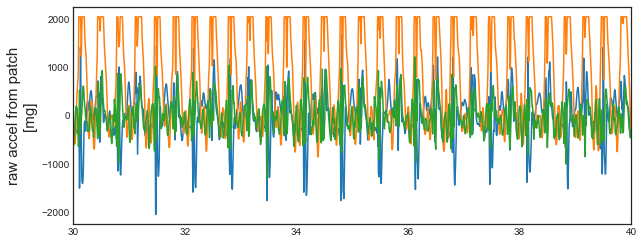

In [14]:
plt.figure(figsize=(10,4))
for sig_name in ['accelX', 'accelY', 'accelZ']:
    plt.plot(time_vector, df_wearable_signals[sig_name].values)
    
plt.ylabel('raw accel from patch\n[{}]'.format(unit_dict['accel']), fontsize=15)
plt.xlim(30,40)

(30.0, 40.0)

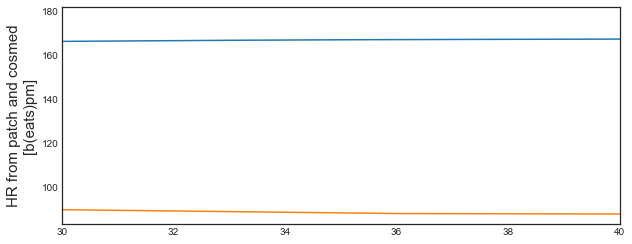

In [15]:
plt.figure(figsize=(10,4))
plt.plot(time_vector, df_wearable_HR['HR_patch'].values) # more accurate
plt.plot(time_vector, df_cosmed_label['HR_cosmed'].values) # less accurate
plt.ylabel('HR from patch and cosmed\n[{}]'.format(unit_dict['HR']), fontsize=15)
plt.xlim(30,40)

(30.0, 40.0)

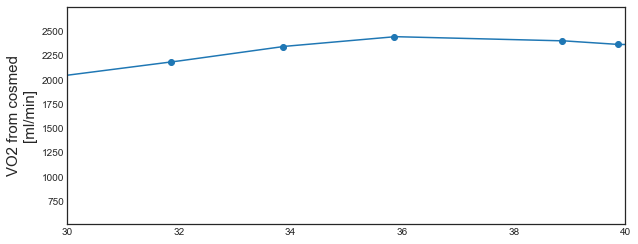

In [16]:
plt.figure(figsize=(10,4))
plt.plot(time_vector, df_cosmed_label['VO2_cosmed'].values)

mask = df_cosmed_label['Sampled_cosmed']==1 # this shows when were cosmed data sampled (about every 2-3 seconds)
plt.scatter(time_vector[mask], df_cosmed_label['VO2_cosmed'].values[mask])
plt.ylabel('VO2 from cosmed\n[{}]'.format(unit_dict['VO2']), fontsize=15)

plt.xlim(30,40)

## High ECG quality

In [62]:
SAMPLE_task_name = 'Baseline'
SAMPLE_subject_id = 212

mask = (df_sync_extracted['subject_id']==SAMPLE_subject_id) & (df_sync_extracted['task']==SAMPLE_task_name)
df_sub_task = df_sync_extracted[mask].copy()
time_vector = df_sub_task['time']
time_vector = time_vector - time_vector.min()

(30.0, 35.0)

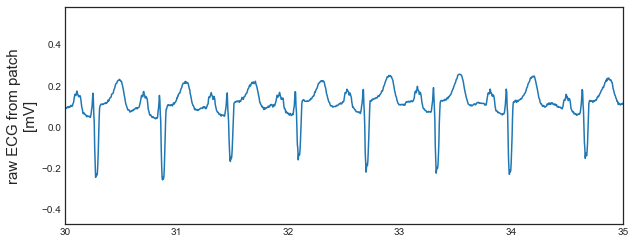

In [63]:
plt.figure(figsize=(10,4))
# for sig_name in ['accelX', 'accelY', 'accelZ']:
plt.plot(time_vector, df_sub_task['ECG'].values)
    
plt.ylabel('raw ECG from patch\n[{}]'.format(unit_dict['ecg']), fontsize=15)
plt.xlim(30,35)

## Poor ECG quality

In [64]:
SAMPLE_task_name = 'Run'
SAMPLE_subject_id = 212

mask = (df_sync_extracted['subject_id']==SAMPLE_subject_id) & (df_sync_extracted['task']==SAMPLE_task_name)
df_sub_task = df_sync_extracted[mask].copy()
time_vector = df_sub_task['time']
time_vector = time_vector - time_vector.min()

(30.0, 35.0)

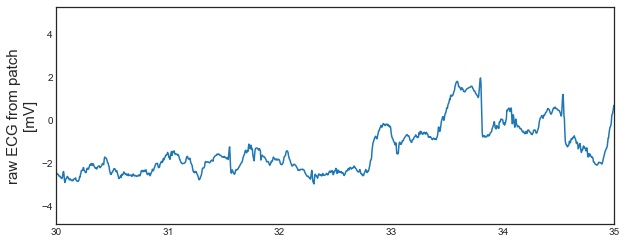

In [65]:
plt.figure(figsize=(10,4))
# for sig_name in ['accelX', 'accelY', 'accelZ']:
plt.plot(time_vector, df_sub_task['ECG'].values)
    
plt.ylabel('raw ECG from patch\n[{}]'.format(unit_dict['ecg']), fontsize=15)
plt.xlim(30,35)

# load RR estimated using patch PPG (best PPG channel was selected based on respiratory quality index) and denoised using U-Net (sampling rate = 1/3 Hz)
## each of the RR estimates represent the RR over a 60s window (-30s to 30s relative to the `time` column)

In [19]:
filedir = '../../data/stage4_UNet_test/CDC_dataset/PPG/AT_block/target/numeric_results/df_outputlabel_val_RR_cosmed.csv'

In [20]:
df_RR_estimates = pd.read_csv(filedir)[['ts_val', 'CV', 'activity', 'label_est', 'label', 'RQI_fft',
       'RQI_kurtosis']]
df_RR_estimates = df_RR_estimates.rename(columns={"CV": "subject_id", "ts_val": "time", })
df_RR_estimates['task'] = [tasks_dict_reversed[int(task_id)] for task_id in df_RR_estimates['activity'].values ]
df_RR_estimates = df_RR_estimates.drop(columns=['activity'])

# need to correct the time vector in df_RR_estimates (will take too much time to correct it the right way)

In [21]:
for subject_id in df_RR_estimates['subject_id'].unique():
    for task_name in df_RR_estimates['task'].unique():
        t_start_4sub_task = t_start_dict[subject_id][task_name]
        mask = (df_RR_estimates['subject_id']==subject_id) & (df_RR_estimates['task']==task_name)
        df_RR_estimates.loc[mask, 'time'] = df_RR_estimates[mask]['time']+t_start_4sub_task

In [22]:
print('all tasks included in this csv files are: {}'.format(df_RR_estimates['task'].unique()))

all tasks included in this csv files are: ['Baseline' 'Recovery 6MWT-R' 'Recovery 6MWT' 'Recovery StairDown1'
 'Recovery Walk' 'Recovery Run' '6MWT' '6MWT-R' 'Walk' 'Run']


# get data for one subject, one task from the `df_RR_estimates` file

In [67]:
SAMPLE_task_name = 'Walk'
SAMPLE_subject_id = 119

mask = (df_RR_estimates['subject_id']==SAMPLE_subject_id) & (df_RR_estimates['task']==SAMPLE_task_name)
df_RR_sub_task = df_RR_estimates[mask].copy()

In [68]:
mask = (df_sync_extracted['subject_id']==SAMPLE_subject_id) & (df_sync_extracted['task']==SAMPLE_task_name)
df_sub_task = df_sync_extracted[mask].copy()

In [69]:
# plt.plot(df_RR_sub_task['label'].values)

In [70]:
# plt.plot(df_sub_task['RR_cosmed'].values[::50])
# plt.plot(df_sub_task['RR_cosmed'].values[::50])

# the samping rate is 1/3 Hz. To confirm, you can compute it as follows:

In [71]:
time_vector = df_RR_sub_task['time']
time_vector = time_vector-time_vector.min()
Fs = np.round(1/np.diff(time_vector).mean(),2)
print('The sampling rate of these data is {}'.format(Fs))

The sampling rate of these data is 0.33


In [72]:
# df_RR_sub_task['time']

In [73]:
# time_vector

# show RR estimates vs. its labels

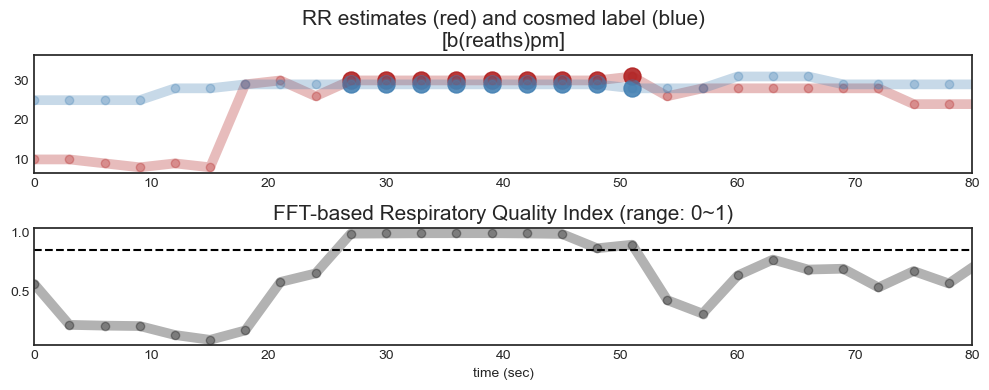

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(10,4), dpi=100)
ax = axes[0]
ax.plot(time_vector, df_RR_sub_task['label_est'].values, linewidth=7, linestyle='-', marker='o', alpha=0.3, color='firebrick')
ax.plot(time_vector, df_RR_sub_task['label'].values, linewidth=7, linestyle='-', marker='o', alpha=0.3, color='steelblue')

# reject poorly estiamted RR
RQI_threshold = 0.85
RQI_mask = df_RR_sub_task['RQI_fft'] > RQI_threshold # only keep estimates with RQI > 0.85 (recommended threshold)

ax.scatter(time_vector[RQI_mask], df_RR_sub_task['label_est'].values[RQI_mask], s=150, alpha=0.9, color='firebrick')
ax.scatter(time_vector[RQI_mask], df_RR_sub_task['label'].values[RQI_mask], s=150, alpha=0.9, color='steelblue')

ax.set_title('RR estimates (red) and cosmed label (blue)\n[{}]'.format(unit_dict['RR']), fontsize=15)
ax.set_xlim(0,80)


ax = axes[1]
ax.plot(time_vector, df_RR_sub_task['RQI_fft'].values, linewidth=7, linestyle='-', marker='o', alpha=0.3, color='black')
ax.axhline(RQI_threshold, color='black', linestyle='--')
ax.set_title('FFT-based Respiratory Quality Index (range: 0~1)', fontsize=15)
ax.set_xlim(0,80)
ax.set_xlabel('time (sec)')

fig.tight_layout()